# Weather State Map Creation

Given the creation of the H1 dataset, weather state maps can be created. Due to the temporal resolution, WS maps can be created for any given month between, multiple months or even years. 

Here is the process to generate global WS maps for a given time period for the H1 dataset:

1. If the desired time period is greater than one year, initalize an empty array (let's say this is called `data`)to aggregate the data from each year.
2. Load one year of data at a time and add the year of data to the initalized array from `step 1` in order to keep track of the total count for each gridbox.
3. Sum all data along the temporal axis (axis=0) to acquire total gridbox counts for all time for all WS.
4. Initialize a new array `total_data` which will be the sum of all data across both temporal and WS axis'. The array `total_data` is the total count of every gridbox.
5. Divide each WS of the `data` array which was summed across time by `total_data` to turn each gridbox from counts to Relative Frequency of Occurance (RFO)
6. Reshape the data to (360, 180), rotate the data by 90 degrees and plot

Practically, there may be some gridboxes that have no counts. In order to account for this, masked arrays are used. The process prescribed above using masked arrays can be seen below.

In [1]:
import os
import gc
import api
import time
import netCDF4
import numpy as np
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.ticker import FormatStrFormatter, FixedFormatter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#%matplotlib

In [3]:
# Find path where data is located, initialize empty array to store data, 
# and determine how many years of data to plot
path = '/run/media/dtropf/Seagate Backup Plus Drive/H1_data/H1_'
data = np.zeros((12,12,360*180))
years = [str(i) for i in range(1984, 2010)]

# Open a year of data at a time, add to the running total, and free memory
# to load next year of data
for year in years:
    h1data = np.load(path+year+'.npy')
    data[:,:,:] = data[:,:,:]+h1data[:,:,:]
    del h1data
    gc.collect()

In [5]:
# Total gridbox count. Data summed along temporal and WS axis'.
total_data = np.sum(np.sum(data,axis=0),axis=0)

# Masked version of total_data used to find and ignore gridboxes without counts
masked_total = np.ma.masked_where(total_data<=0, total_data)

# Masked data summed along temporal axis. This ignores gridboxes without counts
# and obtains counts for gridboxes of each WS
masked_data = np.ma.masked_where(np.sum(data,axis=0)<=0, np.sum(data,axis=0))

# Intialize new array which stores the masked_data in RFO
# form by dividing each WS of masked_data by total_data
normed_data = np.ma.zeros((12,360*180))
for i in range(12):
    normed_data[i,:] = masked_data[i,:]/total_data

# Plotting Specifics

For purposes of reproduction, a colorbar is created to resemble as closely as possible the one used in figure 2 of the following [link](https://www.noaacrest.org/rscg/Products/WS/glcluster.html).



In [6]:
cf = open('cmap3.txt')
clist = [""+cnum+"" for cnum in cf.read().splitlines()]
cm = mpl.colors.LinearSegmentedColormap.from_list('custom', clist, N=256)
vmin = np.amin(normed_data)
vmax = np.amax(normed_data)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

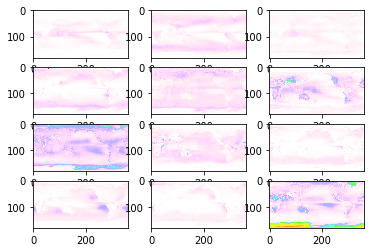

In [7]:
fig, axes = plt.subplots(nrows=4,ncols=3)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.rot90((normed_data[i,:].reshape(360,180))), cmap=cm, norm=norm)

# Plotting with Cartopy

The above WS plots seems reasonable as they outline the continents and are quite similar to those seen [here](https://www.noaacrest.org/rscg/Products/WS/glcluster.html) in Figure 2.

Lets spruce up the plots by adding a colorbar, titles, RFOs for each WS, and coastlines using `cartopy`.

/home/dtropf/anaconda3/envs/cartopyTest/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


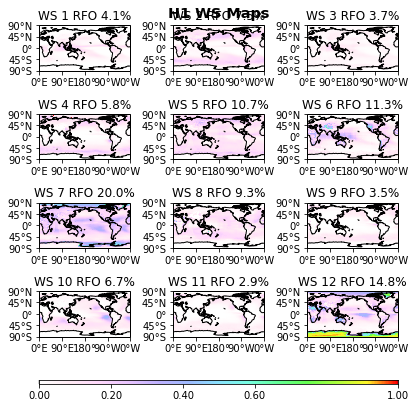

In [8]:
rfo_list = api.rfo(normed_data)

projection = ccrs.PlateCarree(central_longitude=180)
axes_class = (GeoAxes, dict(map_projection=projection))

fig = plt.figure(figsize=(10,5.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(4, 3),
                axes_pad=0.6,
                cbar_pad=0.0,
                cbar_size='3%',
                cbar_mode = 'single',
                cbar_location = 'bottom',
                label_mode='', aspect='equal')  # note the empty label_mode

lats = np.arange(-90, 90)
lons = np.arange(-180, 180)

for i, ax in enumerate(axgr):
    ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    ax.set_yticks(np.linspace(-90, 90, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines()
    ax.set_global()
    ax.set_title('WS '+str(i+1)+' RFO '+('{:.1f}%'.format(rfo_list[i]*100)))
    extent=[-180,180,-90,90]
    im = ax.imshow((normed_data[i,:].reshape(360,180).T), cmap=cm, norm=norm, transform=projection, interpolation='none', extent=extent)

axgr.cbar_axes[0].colorbar(im)
xticks = [0,.2,.4,.6,vmax]
axgr.cbar_axes[0].set_xticks(xticks)
xticks = ['{:.2f}'.format(tick) for tick in xticks]
axgr.cbar_axes[0].xaxis.set_major_formatter(FixedFormatter(xticks))
fig.suptitle("H1 WS Maps", fontweight='extra bold', fontsize='x-large')
fig.tight_layout()
plt.show()